In [1]:
from sklearn import model_selection, metrics, utils
import tensorflow as tf
import keras.callbacks as callbacks
import numpy as np
import pandas as pd
from amp.models.discriminators import veltri_amp_classifier
import amp.data_utils.data_loader as data_loader
import amp.utils.classifier_utils as cu
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import amp.data_utils.sequence as du_sequence

seed = 36
np.random.seed(seed)

Using TensorFlow backend.


In [2]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)

In [3]:
VOCAB_SIZE = 21 #20 amino acids and 1 character (0) for padding
MIN_LENGTH = 0
MAX_LENGTH = 25

In [4]:
from keras import preprocessing

sigmoid = lambda x: 1 / (1 + np.exp(4 * (-x + 1.5)))
inv_sigmoid = lambda x: -0.25 * np.log((1/x) - 1) + 1.5

alphabet = list('ACDEFGHIKLMNPQRSTVWY')

def to_one_hot(x):
    alphabet = list('ACDEFGHIKLMNPQRSTVWY')
    classes = range(1, 21)
    aa_encoding = dict(zip(alphabet, classes))
    return [[aa_encoding[aa] for aa in seq] for seq in x]

def pad(x):
    return preprocessing.sequence.pad_sequences(
        x,
        maxlen=MAX_LENGTH,
        padding='post',
        value=0.0
    )

In [5]:
data_manager = data_loader.AMPDataManager(
    '../data/unlabelled_positive.csv',
    '../data/unlabelled_negative.csv',
    min_len=MIN_LENGTH,
    max_len=MAX_LENGTH)

positives, negatives = data_manager.get_data()

(array([ 104.,  286.,  599., 2658., 2289.,  872., 1186.,  926., 1268.,
         943.]),
 array([ 2. ,  4.3,  6.6,  8.9, 11.2, 13.5, 15.8, 18.1, 20.4, 22.7, 25. ]),
 <BarContainer object of 10 artists>)

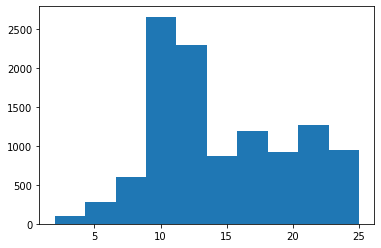

In [6]:
plt.hist([len(x) for x in negatives.Sequence])

In [7]:
data_manager = data_loader.AMPDataManager(
    '../data/unlabelled_positive.csv',
    '../data/unlabelled_negative.csv',
    min_len=MIN_LENGTH,
    max_len=MAX_LENGTH)

amp_x, amp_y = data_manager.get_merged_data()
amp_x_train, amp_x_test, amp_y_train, amp_y_test = train_test_split(amp_x, amp_y, test_size=0.1, random_state=36)

negatives_x_train = amp_x_train[amp_y_train == 0]
negatives_x_test = amp_x_test[amp_y_test == 0]

/home/tgrzegorz/miniconda3/envs/amp/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/tgrzegorz/miniconda3/envs/amp/lib/python3.8/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [8]:
from amp.utils.generate_peptides import translate_peptide

(array([  73.,  256.,  495., 2315., 2091.,  772., 1114.,  861., 1123.,
         920.]),
 array([ 2. ,  4.3,  6.6,  8.9, 11.2, 13.5, 15.8, 18.1, 20.4, 22.7, 25. ]),
 <BarContainer object of 10 artists>)

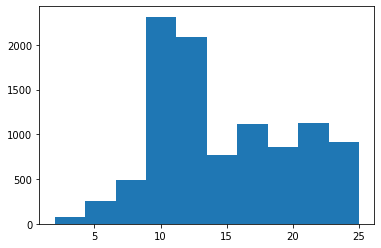

In [9]:
plt.hist([len(translate_peptide(x)) for x in negatives_x_train])

In [10]:
len(negatives_x_train)

10020

In [11]:
# Restrict the length
ecoli_df = pd.read_csv('../data/mic_data.csv')
mask = (ecoli_df['sequence'].str.len() <= MAX_LENGTH) & (ecoli_df['sequence'].str.len() >= MIN_LENGTH)
ecoli_df = ecoli_df.loc[mask]
mic_x = du_sequence.pad(du_sequence.to_one_hot(ecoli_df['sequence']))
mic_y = ecoli_df.value

(array([ 12.,  34., 136., 551., 694., 802., 745., 363.,  60.,  47.]),
 array([-1.32395466, -0.84104419, -0.35813373,  0.12477673,  0.6076872 ,
         1.09059766,  1.57350812,  2.05641859,  2.53932905,  3.02223951,
         3.50514998]),
 <BarContainer object of 10 artists>)

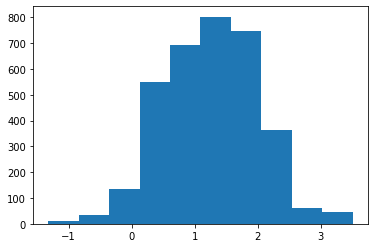

In [12]:
plt.hist(mic_y)

(array([ 21.,  43., 131., 509., 600., 376., 545., 415., 307., 497.]),
 array([ 2. ,  4.3,  6.6,  8.9, 11.2, 13.5, 15.8, 18.1, 20.4, 22.7, 25. ]),
 <BarContainer object of 10 artists>)

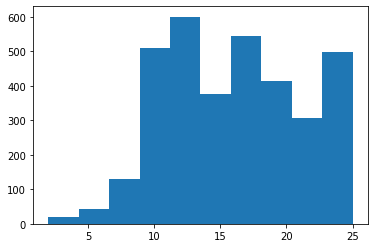

In [13]:
plt.hist([len(translate_peptide(x)) for x in mic_x])

In [14]:
mic_x_train, mic_x_test, mic_y_train, mic_y_test = train_test_split(mic_x, mic_y, test_size=0.1, random_state=36)
mic_y_train = (mic_y_train < 1.5).astype(int)
mic_y_test = (mic_y_test < 1.5).astype(int)

In [15]:
x_train = np.concatenate([mic_x_train, negatives_x_train])
y_train = np.concatenate([mic_y_train, np.zeros(len(negatives_x_train))])

x_test = np.concatenate([mic_x_test, negatives_x_test])
y_test = np.concatenate([mic_y_test.astype(int), np.zeros(len(negatives_x_test))])


In [16]:
cv = model_selection.StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

Fold 1


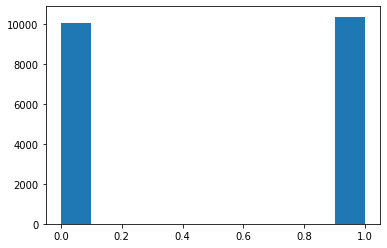

/home/tgrzegorz/miniconda3/envs/amp/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


Train on 20457 samples, validate on 1312 samples
Epoch 1/32
20457/20457 [==============================] - 4s 184us/step - loss: 0.2569 - accuracy: 0.9005 - val_loss: 0.1954 - val_accuracy: 0.9184
Epoch 2/32
20457/20457 [==============================] - 2s 104us/step - loss: 0.1599 - accuracy: 0.9460 - val_loss: 0.2108 - val_accuracy: 0.9123
Epoch 3/32
20457/20457 [==============================] - 2s 106us/step - loss: 0.1192 - accuracy: 0.9611 - val_loss: 0.1698 - val_accuracy: 0.9390
Epoch 4/32
20457/20457 [==============================] - 2s 103us/step - loss: 0.0943 - accuracy: 0.9704 - val_loss: 0.2068 - val_accuracy: 0.9299
Epoch 5/32
20457/20457 [==============================] - 2s 98us/step - loss: 0.0853 - accuracy: 0.9730 - val_loss: 0.2018 - val_accuracy: 0.9299
Epoch 6/32
20457/20457 [==============================] - 2s 105us/step - loss: 0.0737 - accuracy: 0.9778 - val_loss: 0.2024 - val_accuracy: 0.9405
Epoch 7/32
20457/20457 [==============================] - 2s 90u

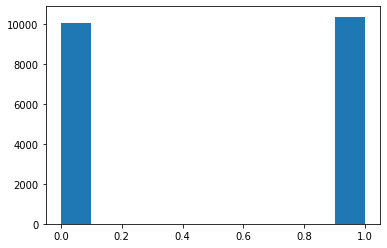

Train on 20457 samples, validate on 1312 samples
Epoch 1/32
20457/20457 [==============================] - 2s 119us/step - loss: 0.2591 - accuracy: 0.8977 - val_loss: 0.2137 - val_accuracy: 0.9078
Epoch 2/32
20457/20457 [==============================] - 2s 93us/step - loss: 0.1554 - accuracy: 0.9473 - val_loss: 0.2003 - val_accuracy: 0.9223
Epoch 3/32
20457/20457 [==============================] - 2s 95us/step - loss: 0.1159 - accuracy: 0.9626 - val_loss: 0.2075 - val_accuracy: 0.9223
Epoch 4/32
20457/20457 [==============================] - 2s 103us/step - loss: 0.0976 - accuracy: 0.9697 - val_loss: 0.1885 - val_accuracy: 0.9352
Epoch 5/32
20457/20457 [==============================] - 2s 97us/step - loss: 0.0836 - accuracy: 0.9751 - val_loss: 0.2324 - val_accuracy: 0.9268
Epoch 6/32
20457/20457 [==============================] - 2s 92us/step - loss: 0.0751 - accuracy: 0.9783 - val_loss: 0.2505 - val_accuracy: 0.9215
Epoch 7/32
20457/20457 [==============================] - 2s 97us/s

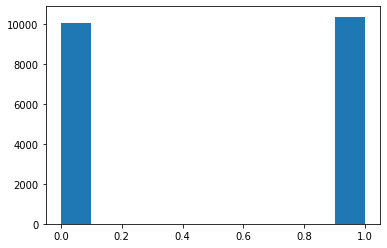

Train on 20457 samples, validate on 1312 samples
Epoch 1/32
20457/20457 [==============================] - 2s 121us/step - loss: 0.2583 - accuracy: 0.8989 - val_loss: 0.1756 - val_accuracy: 0.9238
Epoch 2/32
20457/20457 [==============================] - 2s 100us/step - loss: 0.1630 - accuracy: 0.9442 - val_loss: 0.1649 - val_accuracy: 0.9375
Epoch 3/32
20457/20457 [==============================] - 2s 94us/step - loss: 0.1164 - accuracy: 0.9624 - val_loss: 0.1916 - val_accuracy: 0.9345
Epoch 4/32
20457/20457 [==============================] - 2s 98us/step - loss: 0.1017 - accuracy: 0.9685 - val_loss: 0.1469 - val_accuracy: 0.9535
Epoch 5/32
20457/20457 [==============================] - 2s 98us/step - loss: 0.0854 - accuracy: 0.9747 - val_loss: 0.1886 - val_accuracy: 0.9436
Epoch 6/32
20457/20457 [==============================] - 2s 93us/step - loss: 0.0773 - accuracy: 0.9778 - val_loss: 0.1856 - val_accuracy: 0.9398
Epoch 7/32
20457/20457 [==============================] - 2s 94us/s

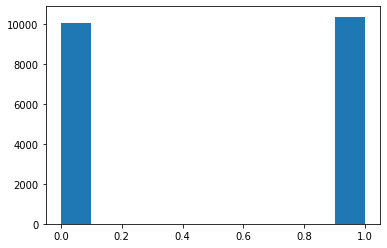

Train on 20462 samples, validate on 1312 samples
Epoch 1/32
20462/20462 [==============================] - 2s 115us/step - loss: 0.2598 - accuracy: 0.8983 - val_loss: 0.2161 - val_accuracy: 0.9192
Epoch 2/32
20462/20462 [==============================] - 2s 101us/step - loss: 0.1619 - accuracy: 0.9455 - val_loss: 0.1923 - val_accuracy: 0.9337
Epoch 3/32
20462/20462 [==============================] - 2s 88us/step - loss: 0.1198 - accuracy: 0.9606 - val_loss: 0.1924 - val_accuracy: 0.9375
Epoch 4/32
20462/20462 [==============================] - 2s 95us/step - loss: 0.0985 - accuracy: 0.9684 - val_loss: 0.2041 - val_accuracy: 0.9428
Epoch 5/32
20462/20462 [==============================] - 2s 107us/step - loss: 0.0811 - accuracy: 0.9752 - val_loss: 0.2061 - val_accuracy: 0.9390
Epoch 6/32
20462/20462 [==============================] - 2s 95us/step - loss: 0.0722 - accuracy: 0.9787 - val_loss: 0.2149 - val_accuracy: 0.9413
Epoch 7/32
20462/20462 [==============================] - 2s 92us/

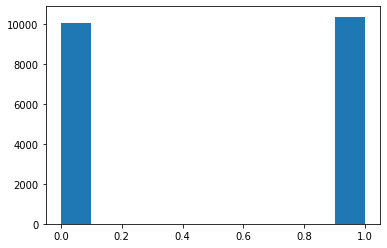

Train on 20462 samples, validate on 1312 samples
Epoch 1/32
20462/20462 [==============================] - 3s 128us/step - loss: 0.2525 - accuracy: 0.9024 - val_loss: 0.2221 - val_accuracy: 0.9055
Epoch 2/32
20462/20462 [==============================] - 2s 94us/step - loss: 0.1556 - accuracy: 0.9452 - val_loss: 0.2435 - val_accuracy: 0.9139
Epoch 3/32
20462/20462 [==============================] - 2s 93us/step - loss: 0.1166 - accuracy: 0.9614 - val_loss: 0.2633 - val_accuracy: 0.8979
Epoch 4/32
20462/20462 [==============================] - 2s 104us/step - loss: 0.0961 - accuracy: 0.9707 - val_loss: 0.2195 - val_accuracy: 0.9154
Epoch 5/32
20462/20462 [==============================] - 2s 94us/step - loss: 0.0814 - accuracy: 0.9755 - val_loss: 0.1994 - val_accuracy: 0.9329
Epoch 6/32
20462/20462 [==============================] - 2s 95us/step - loss: 0.0733 - accuracy: 0.9784 - val_loss: 0.2097 - val_accuracy: 0.9360
Epoch 7/32
20462/20462 [==============================] - 2s 102us/

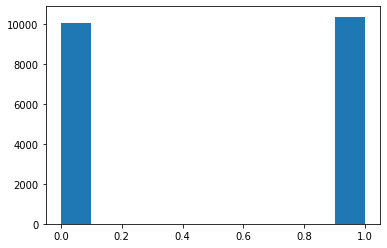

Train on 20462 samples, validate on 1312 samples
Epoch 1/32
20462/20462 [==============================] - 3s 126us/step - loss: 0.2573 - accuracy: 0.9040 - val_loss: 0.2570 - val_accuracy: 0.8986
Epoch 2/32
20462/20462 [==============================] - 2s 95us/step - loss: 0.1607 - accuracy: 0.9445 - val_loss: 0.2249 - val_accuracy: 0.9139
Epoch 3/32
20462/20462 [==============================] - 2s 97us/step - loss: 0.1138 - accuracy: 0.9632 - val_loss: 0.2141 - val_accuracy: 0.9367
Epoch 4/32
20462/20462 [==============================] - 2s 97us/step - loss: 0.0932 - accuracy: 0.9705 - val_loss: 0.2395 - val_accuracy: 0.9322
Epoch 5/32
20462/20462 [==============================] - 2s 91us/step - loss: 0.0788 - accuracy: 0.9753 - val_loss: 0.2243 - val_accuracy: 0.9390
Epoch 6/32
20462/20462 [==============================] - 2s 92us/step - loss: 0.0719 - accuracy: 0.9785 - val_loss: 0.2186 - val_accuracy: 0.9405
Epoch 7/32
20462/20462 [==============================] - 2s 102us/s

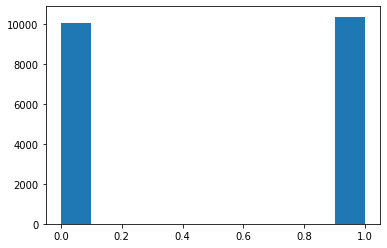

Train on 20462 samples, validate on 1312 samples
Epoch 1/32
20462/20462 [==============================] - 2s 108us/step - loss: 0.2558 - accuracy: 0.8989 - val_loss: 0.1990 - val_accuracy: 0.9131
Epoch 2/32
20462/20462 [==============================] - 2s 99us/step - loss: 0.1534 - accuracy: 0.9482 - val_loss: 0.2165 - val_accuracy: 0.9101
Epoch 3/32
20462/20462 [==============================] - 2s 99us/step - loss: 0.1149 - accuracy: 0.9637 - val_loss: 0.2195 - val_accuracy: 0.9306
Epoch 4/32
20462/20462 [==============================] - 2s 90us/step - loss: 0.0958 - accuracy: 0.9697 - val_loss: 0.2127 - val_accuracy: 0.9322
Epoch 5/32
20462/20462 [==============================] - 2s 101us/step - loss: 0.0825 - accuracy: 0.9742 - val_loss: 0.2298 - val_accuracy: 0.9314
Epoch 6/32
20462/20462 [==============================] - 2s 100us/step - loss: 0.0705 - accuracy: 0.9786 - val_loss: 0.2268 - val_accuracy: 0.9299
Epoch 7/32
20462/20462 [==============================] - 2s 91us/

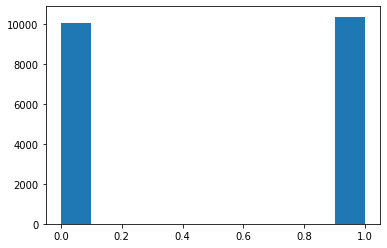

Train on 20462 samples, validate on 1312 samples
Epoch 1/32
20462/20462 [==============================] - 2s 111us/step - loss: 0.2542 - accuracy: 0.9035 - val_loss: 0.1944 - val_accuracy: 0.9261
Epoch 2/32
20462/20462 [==============================] - 2s 93us/step - loss: 0.1627 - accuracy: 0.9432 - val_loss: 0.2643 - val_accuracy: 0.8971
Epoch 3/32
20462/20462 [==============================] - 2s 104us/step - loss: 0.1204 - accuracy: 0.9611 - val_loss: 0.2023 - val_accuracy: 0.9352
Epoch 4/32
20462/20462 [==============================] - 2s 90us/step - loss: 0.1015 - accuracy: 0.9680 - val_loss: 0.2148 - val_accuracy: 0.9352
Epoch 5/32
20462/20462 [==============================] - 2s 93us/step - loss: 0.0854 - accuracy: 0.9743 - val_loss: 0.2171 - val_accuracy: 0.9367
Epoch 6/32
20462/20462 [==============================] - 2s 106us/step - loss: 0.0775 - accuracy: 0.9762 - val_loss: 0.2202 - val_accuracy: 0.9390
Epoch 7/32
20462/20462 [==============================] - 2s 96us/

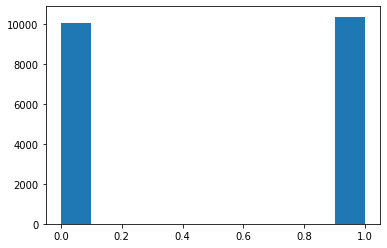

Train on 20462 samples, validate on 1312 samples
Epoch 1/32
20462/20462 [==============================] - 2s 122us/step - loss: 0.2559 - accuracy: 0.9004 - val_loss: 0.2857 - val_accuracy: 0.8971
Epoch 2/32
20462/20462 [==============================] - 2s 93us/step - loss: 0.1554 - accuracy: 0.9478 - val_loss: 0.2095 - val_accuracy: 0.9245
Epoch 3/32
20462/20462 [==============================] - 2s 100us/step - loss: 0.1203 - accuracy: 0.9605 - val_loss: 0.2189 - val_accuracy: 0.9276
Epoch 4/32
20462/20462 [==============================] - 2s 96us/step - loss: 0.0997 - accuracy: 0.9696 - val_loss: 0.2431 - val_accuracy: 0.9253
Epoch 5/32
20462/20462 [==============================] - 2s 92us/step - loss: 0.0844 - accuracy: 0.9746 - val_loss: 0.2178 - val_accuracy: 0.9360
Epoch 6/32
20462/20462 [==============================] - 2s 95us/step - loss: 0.0757 - accuracy: 0.9771 - val_loss: 0.2369 - val_accuracy: 0.9223
Epoch 7/32
20462/20462 [==============================] - 2s 94us/s

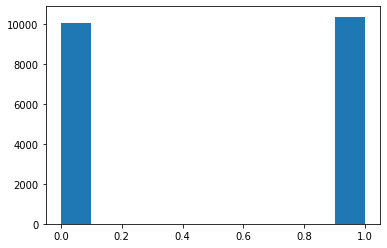

Train on 20463 samples, validate on 1311 samples
Epoch 1/32
20463/20463 [==============================] - 3s 126us/step - loss: 0.2596 - accuracy: 0.9002 - val_loss: 0.2362 - val_accuracy: 0.9115
Epoch 2/32
20463/20463 [==============================] - 2s 89us/step - loss: 0.1608 - accuracy: 0.9471 - val_loss: 0.1943 - val_accuracy: 0.9275
Epoch 3/32
20463/20463 [==============================] - 2s 91us/step - loss: 0.1153 - accuracy: 0.9641 - val_loss: 0.2363 - val_accuracy: 0.9252
Epoch 4/32
20463/20463 [==============================] - 2s 103us/step - loss: 0.0968 - accuracy: 0.9699 - val_loss: 0.2820 - val_accuracy: 0.8986
Epoch 5/32
20463/20463 [==============================] - 2s 93us/step - loss: 0.0821 - accuracy: 0.9743 - val_loss: 0.1920 - val_accuracy: 0.9321
Epoch 6/32
20463/20463 [==============================] - 2s 92us/step - loss: 0.0706 - accuracy: 0.9785 - val_loss: 0.1919 - val_accuracy: 0.9336
Epoch 7/32
20463/20463 [==============================] - 2s 97us/s

In [17]:
c = 0
oof_preds = np.zeros((len(x_train), 1))
test_preds = []
mic_test_pred = []
for train, val in cv.split(x_train, y_train):
    c += 1
    print('Fold %s' % c)
    mic_classifier = veltri_amp_classifier.VeltriAMPClassifierFactory.get_default(25)
    mic_classifier_model = mic_classifier()
    x_train_fold = x_train[train]
    y_train_fold = y_train[train]
    positives = x_train_fold[y_train_fold == 1].tolist() * 5
    x_train_fold = np.concatenate([x_train_fold, positives])
    y_train_fold = np.concatenate([y_train_fold, np.ones(len(positives))])
    plt.hist(y_train_fold)
    plt.show()
    mic_classifier_model.fit(
        x_train_fold, y_train_fold,
        epochs=32,
        batch_size=64,
        validation_data = (x_train[val], y_train[val]),
        verbose=1,
        callbacks=[callbacks.EarlyStopping(patience=7)],        
)
    test_pred = mic_classifier_model.predict(x_test, batch_size=10000)
    mic_pred = mic_classifier_model.predict(mic_x_test, batch_size=10000)
    test_preds.append(test_pred)
    mic_test_pred.append(mic_pred)
    oof_preds[val] = mic_classifier_model.predict(x_train[val])

In [18]:
test_avg = np.mean(np.asarray(test_preds), axis=0).flatten()
mic_test_avg = np.mean(np.asarray(mic_test_pred), axis=0).flatten()
test_avg_bin = np.where(test_avg > 0.5, 1, 0)
mic_test_bin = np.where(mic_test_avg > 0.5, 1, 0)
val_preds_bin = np.where(oof_preds > 0.5, 1, 0)

In [20]:
print("Full test classification report")
print(classification_report(y_test, test_avg_bin))
print("Known mic only classification report")
print(classification_report(mic_y_test, mic_test_bin))


Full test classification report
              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97      1253
         1.0       0.76      0.85      0.80       203

    accuracy                           0.94      1456
   macro avg       0.87      0.90      0.89      1456
weighted avg       0.95      0.94      0.94      1456

Known mic only classification report
              precision    recall  f1-score   support

           0       0.75      0.65      0.70       142
           1       0.78      0.85      0.81       203

    accuracy                           0.77       345
   macro avg       0.76      0.75      0.75       345
weighted avg       0.77      0.77      0.76       345



In [21]:
print(f'Validation AUC: {metrics.roc_auc_score(y_train, oof_preds)}')
print(f'Test AUC: {metrics.roc_auc_score(y_test, test_avg)}')

Validation AUC: 0.9663105388095483
Test AUC: 0.9674751040851709


In [22]:
print(f'Validation F1: {metrics.f1_score(y_train, val_preds_bin)}')
print(f'Test F1: {metrics.f1_score(y_test, test_avg_bin)}')

Validation F1: 0.7930014785608673
Test F1: 0.8046511627906977


In [23]:
print(f'Validation sensitivity: {metrics.recall_score(y_train, val_preds_bin)}')
print(f'Test sensitivity: {metrics.recall_score(y_test, test_avg_bin)}')

Validation sensitivity: 0.8367134685387415
Test sensitivity: 0.8522167487684729


In [24]:
tn, fp, fn, tp = metrics.confusion_matrix(y_train, val_preds_bin).ravel()
specificity_val = tn / (tn+fp)
tn, fp, fn, tp = metrics.confusion_matrix(y_test, test_avg_bin).ravel()
specificity_test = tn / (tn+fp)
print(f'Validation specificity: {specificity_val}')
print(f'Test specificity: {specificity_test}')

Validation specificity: 0.9530189353340479
Test specificity: 0.9569034317637669


In [25]:
print(f'Validation accuracy: {metrics.accuracy_score(y_train, val_preds_bin)}')
print(f'Test accuracy: {metrics.accuracy_score(y_test, test_avg_bin)}')

Validation accuracy: 0.9359707294763321
Test accuracy: 0.9423076923076923


In [26]:
print(f'Validation MCC: {metrics.matthews_corrcoef(y_train, val_preds_bin)}')
print(f'Test MCC: {metrics.matthews_corrcoef(y_test, test_avg_bin)}')

Validation MCC: 0.7566967058353357
Test MCC: 0.772587571798614


In [27]:
print(f'Validation Confusion Matrix:\n {metrics.confusion_matrix(y_train, val_preds_bin)}')

Validation Confusion Matrix:
 [[10670   526]
 [  314  1609]]


In [28]:
print(f'Test Confusion Matrix:\n {metrics.confusion_matrix(y_test, test_avg_bin)}')

Test Confusion Matrix:
 [[1199   54]
 [  30  173]]


Train on 22734 samples, validate on 345 samples
Epoch 1/32
22734/22734 [==============================] - 3s 114us/step - loss: 0.2556 - accuracy: 0.9016 - val_loss: 0.7835 - val_accuracy: 0.6609
Epoch 2/32
22734/22734 [==============================] - 2s 102us/step - loss: 0.1555 - accuracy: 0.9451 - val_loss: 0.8281 - val_accuracy: 0.7159
Epoch 3/32
22734/22734 [==============================] - 2s 99us/step - loss: 0.1152 - accuracy: 0.9627 - val_loss: 0.8659 - val_accuracy: 0.7217
Epoch 4/32
22734/22734 [==============================] - 2s 100us/step - loss: 0.0970 - accuracy: 0.9693 - val_loss: 0.9337 - val_accuracy: 0.7420
Epoch 5/32
22734/22734 [==============================] - 2s 100us/step - loss: 0.0820 - accuracy: 0.9749 - val_loss: 1.0230 - val_accuracy: 0.7217
Epoch 6/32
22734/22734 [==============================] - 2s 98us/step - loss: 0.0773 - accuracy: 0.9762 - val_loss: 0.9292 - val_accuracy: 0.7391
Epoch 7/32
22734/22734 [==============================] - 2s 101us

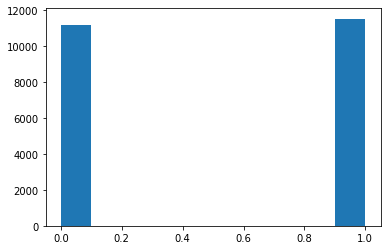

In [33]:
mic_classifier = veltri_amp_classifier.VeltriAMPClassifierFactory.get_default(25)
mic_classifier_model = mic_classifier()
positives = x_train[y_train == 1].tolist() * 5
x_train_final = np.concatenate([x_train, positives])
y_train_final = np.concatenate([y_train, np.ones(len(positives))])
plt.hist(y_train_final)
mic_classifier_model.fit(
        x_train_final, y_train_final,
        epochs=32,
        batch_size=64,
        validation_data=(mic_x_test, mic_y_test),
        verbose=1,
        callbacks=[callbacks.EarlyStopping(patience=7)],
)

In [34]:
from amp.utils import basic_model_serializer
bms = basic_model_serializer.BasicModelSerializer()
bms.save_model(regressor, '../models/mic_classifier')